# 10 - Regularization Techniques and Feature Importance Analysis

## Aufgabe 10.1

In [4]:
import pandas as pd
df = pd.read_csv('data/college.csv', index_col=0)
df = pd.get_dummies(df, columns=['Private'], drop_first=True)
df = df.rename(columns={'Private_Yes': 'Private'})
df.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1


In [10]:
# 10.1 a) Split
from sklearn.model_selection import train_test_split

X = df.drop('Apps', axis=1)
y = df['Apps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


In [28]:
import operator
import time
import itertools
import statsmodels.api as sm
import pandas as pd

def processSubset(feature_set, X, y):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    rss = regr.ssr
    aic = regr.aic
    return {'model':regr, 'RSS':rss, 'AIC':aic}

def getBest(X, y, k):
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo, X, y))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest AIC
    best_model = models.loc[models['AIC'].argmin()]
    
    toc = time.time()
    print(
        "Processed", models.shape[0], "models on", k,
        "predictors in", (toc-tic), "seconds."
        )
    
    # Return the best model, along with some other
    # useful information about the model
    return best_model

models_best = pd.DataFrame(columns=['RSS', 'AIC', 'model'])

start = time.time()
for i in range(1,18):
    models_best.loc[i] = getBest(X_train, y_train, i)

end = time.time()
print("Total elapsed time:", (end-start), "seconds.")
print(models_best)

Processed 17 models on 1 predictors in 0.0095062255859375 seconds.
Processed 136 models on 2 predictors in 0.06125473976135254 seconds.
Processed 680 models on 3 predictors in 0.3839128017425537 seconds.
Processed 2380 models on 4 predictors in 5.835301399230957 seconds.
Processed 6188 models on 5 predictors in 3.567633628845215 seconds.
Processed 12376 models on 6 predictors in 7.845467567443848 seconds.
Processed 19448 models on 7 predictors in 19.49787998199463 seconds.
Processed 24310 models on 8 predictors in 42.625856161117554 seconds.
Processed 24310 models on 9 predictors in 54.97859859466553 seconds.
Processed 19448 models on 10 predictors in 51.53018260002136 seconds.
Processed 12376 models on 11 predictors in 31.048662900924683 seconds.
Processed 6188 models on 12 predictors in 14.853821039199829 seconds.
Processed 2380 models on 13 predictors in 4.872140407562256 seconds.
Processed 680 models on 14 predictors in 1.1250293254852295 seconds.
Processed 136 models on 15 predict

In [30]:
best_model_res = models_best.loc[11, 'model']
y_pred = best_model_res.predict(X_test[[
    'Accept', 'Top10perc', 'Top25perc', 'F.Undergrad', 'Outstate',
    'Room.Board', 'PhD', 'Expend', 'Terminal', 'Grad.Rate', 'Private'
    ]]
)
print('{:.6E}'.format(sum((y_test - y_pred) ** 2)))

8.815695E+12


In [36]:
# 10.1 c) ridge regression
from sklearn.linear_model import RidgeCV
import numpy as np

alphas = 10**(np.linspace(-4,2,100))
ridge = RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)
print(ridge.alpha_)
print(ridge.coef_)


# Calculate RSS
y_pred = ridge.predict(X_test)
print('{:.6E}'.format(sum((y_test - y_pred) ** 2)))



12.32846739442066
[ 1.56851476e+00 -7.50787290e-01  5.29084013e+01 -1.66682470e+01
  6.20816357e-02  2.75588385e-02 -1.03449020e-01  1.77776513e-01
 -6.98506372e-02  1.46205597e-02 -8.27418428e+00 -2.49900488e+00
  1.58596970e+01  1.43923648e-01  8.19321496e-02  8.64162378e+00
 -2.57537379e+02]
1.257438E+08


In [ ]:
# 10.1 d) lasso regression
from sklearn.linear_model import LassoCV
import numpy as np

alphas = 10**(np.linspace(-4,2,100))
lasso = LassoCV(alphas=alphas, cv=5).fit(X_train, y_train)
print(lasso.alpha_)
print(lasso.coef_)

y_pred = lasso.predict(X_test)
print('{:.6E}'.format(sum((y_test - y_pred) ** 2)))

57.223676593502205
[ 1.56775019e+00 -7.36208483e-01  5.05094914e+01 -1.49853358e+01
  7.04428189e-02  2.77885542e-02 -1.18698891e-01  1.75912903e-01
 -8.18877078e-02  5.82737420e-03 -6.64062723e+00 -1.56719831e+00
  1.25245123e+01 -6.89838846e-02  8.27799398e-02  7.87288673e+00
 -0.00000000e+00]
1.329900E+08


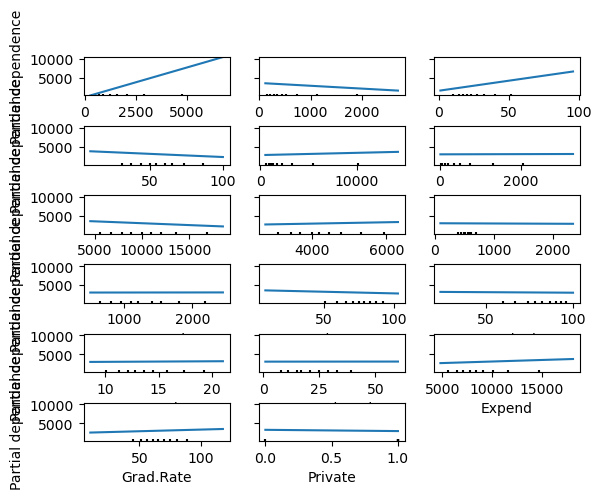

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt 

feature_names = ['Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
    'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal',
    'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
    'Grad.Rate', 'Private'
    ]

lr = LinearRegression().fit(X_train, y_train)
# change X to get PDP for test set
disp = plot_partial_dependence(lr, X=X_train, features=feature_names)
plt.tight_layout()
# Adjust the spacing between subplots, so that feature name can be seen
plt.subplots_adjust(
    left = 0.125,
    right = 0.9,
    bottom = 0.1,
    top = 0.9,
    wspace = 0.2,
    hspace = 0.8
    )
plt.show()